## Se importan librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
from pyspark.ml.feature import Word2Vec

## Se crea el contexto y la sesion de spark

In [4]:
conf = SparkConf().set("spark.ui.port", "4050")

# creamos el contexto y la sesión
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/12 16:04:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Se leen los datos

In [5]:
data_covid = spark.read.csv('./data/covid_articles_raw.csv', header=True, multiLine=True, escape='"')
data_covid.show()

+--------------------+--------------------+--------+
|               title|             content|category|
+--------------------+--------------------+--------+
|Looking into the ...|Hi, what are you ...| general|
|Hexo refiles fina...|New York reported...| general|
|Japan raid, Turke...|Hi, what are you ...| general|
|Pope's bodyguards...|Hi, what are you ...| general|
|Lebanon denies pr...|Hi, what are you ...| general|
|Lebanese lawyers ...|Hi, what are you ...| general|
|' I did it alone ...|Hi, what are you ...| general|
|Ghosn escape spar...|Hi, what are you ...| general|
|Mexico's Santiago...|Hi, what are you ...| general|
|Fired British veg...|Hi, what are you ...| general|
|US places ban on ...|Hi, what are you ...| general|
|Medicinal cannabi...|Hi, what are you ...| general|
|2020 trends to wa...|Or wait...\nSearc...| general|
|Madonna rings in ...|Hi, what are you ...| general|
|Three Industrial ...|\nWith the end of...|business|
|My experience of ...|“ Helen, I’ m so ...|   

## Se selecciona la columna title

In [6]:
title = data_covid.select('title')

# **Se toma una muestra de 10%** de la data para TEST y se toma una semilla de 3

In [7]:
sample_title = title.sample(fraction = .1, seed = 3)

## Se hace un Split de la columna title y se pone todo el texto en minusculas para TEST

In [8]:
titles = sample_title.withColumn('title_splitted',split(lower(col('title'))," "))

In [9]:
titles.take(2)

[Row(title='An elegy for cash: the technology we might never replace', title_splitted=['an', 'elegy', 'for', 'cash:', 'the', 'technology', 'we', 'might', 'never', 'replace']),
 Row(title='POSTPONED - SpaMedica CET Event – Cataract & AMD Training', title_splitted=['postponed', '-', 'spamedica', 'cet', 'event', '–', 'cataract', '&', 'amd', 'training'])]

## Se aplica el metodo de word2vec con un tamaño de vector 100 , con una minima frecuencia por palabra de 0, 100 iteraciones maximo para TEST

In [10]:
w2v = Word2Vec(vectorSize = 100, minCount = 0, maxIter = 10, inputCol = 'title_splitted', outputCol = 'features')

## Se entrena los datos TEST el modelo con titles

In [11]:
model = w2v.fit(titles)

22/10/12 16:05:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/12 16:05:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Se generan los emmbedings de los titulos con el metodo transform para TEST

In [12]:
result =model.transform(titles)

## Se entrena un modelo TEST usando kmeans para 100 iteraciones y 3 cluster

In [13]:
kmeans = KMeans().setMaxIter(100).setK(3).setSeed(1)
kmeans_model = kmeans.fit(result)

## Se hace la predicción de las categorias del modelo TEST

In [14]:
predictions = kmeans_model.transform(result)
predictions.show()

+-----------------------------+-----------------------------+--------------------+----------+
|                        title|               title_splitted|            features|prediction|
+-----------------------------+-----------------------------+--------------------+----------+
|         An elegy for cash...|         [an, elegy, for, ...|[0.07284992113709...|         1|
|         POSTPONED - SpaMe...|         [postponed, -, sp...|[-0.0501381957903...|         1|
|特朗普盲目走向战争 by Djav...|[特朗普盲目走向战争, by, d...|[-0.3113546185195...|         1|
|         Switzerland grapp...|         [switzerland, gra...|[0.08260701234186...|         0|
|         Essential Science...|         [essential, scien...|[0.03192753484472...|         1|
|         Maurice West talk...|         [maurice, west, t...|[0.06545637590953...|         1|
|         Nudge in a new di...|         [nudge, in, a, ne...|[-0.1012724531548...|         1|
|         The Big Picture O...|         [the, big, pictur...|[-0.0512590818107

# Ahora ejecutamos el modelo para todos los datos TRAIN

## Se selecciona la columna title_splitted y se hace un split que tambien pone cada palabra en minusculas para TRAIN

In [159]:
titles = title.withColumn('title_splitted',split(lower(col('title'))," "))
#w2v_all = Word2Vec(vectorSize = 100, minCount = 0, maxIter = 10, inputCol = 'title_splitted', outputCol = 'features')

In [160]:
titles.take(2)

[Row(title='Looking into the truth about modern workplace environments', title_splitted=['looking', 'into', 'the', 'truth', 'about', 'modern', 'workplace', 'environments']),
 Row(title='Hexo refiles financial statements', title_splitted=['hexo', 'refiles', 'financial', 'statements'])]

## Se hace una transformación de los datos para poder entrenar el modelo para TRAIN

In [161]:
result_all = model.transform(titles)

## Se entrena el modelo con Kmeans con todos los datos TRAIN

In [162]:
predictions_all = kmeans_model.transform(result_all)
predictions_all.show()

+--------------------+--------------------+--------------------+----------+
|               title|      title_splitted|            features|prediction|
+--------------------+--------------------+--------------------+----------+
|Looking into the ...|[looking, into, t...|[0.11508974875323...|         1|
|Hexo refiles fina...|[hexo, refiles, f...|[0.01756128668785...|         2|
|Japan raid, Turke...|[japan, raid,, tu...|[-0.0346653730084...|         0|
|Pope's bodyguards...|[pope's, bodyguar...|[-0.0401004962623...|         0|
|Lebanon denies pr...|[lebanon, denies,...|[0.08723537181504...|         0|
|Lebanese lawyers ...|[lebanese, lawyer...|[0.06957159191370...|         0|
|' I did it alone ...|[', i, did, it, a...|[0.09664490615779...|         0|
|Ghosn escape spar...|[ghosn, escape, s...|[-0.0045131142768...|         0|
|Mexico's Santiago...|[mexico's, santia...|[-0.0865528859198...|         0|
|Fired British veg...|[fired, british, ...|[0.04300085561616...|         0|
|US places b

# CATEGORIA 2 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

## Filtramos la categoria 2 y la asignamos a la variable \_word2\_

In [164]:
word2 = predictions_all.filter(predictions_all.prediction == 2)

## Luego seleccionamos solo la columna title_splitted y la almacenamos en la variable \__word2_title_split\__

In [165]:
word2_title_split = word2.select("title_splitted")

## Importamos librerias necesarias para analizar la nube de palabras de la categoria 2

In [172]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords


## Se crea una función CLEAN_TEXT que limpia las palabras de caracteres y datos redundantes

In [103]:
def clean_text(line:str) -> str:
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-“”'
    words = ['covid 19','covid19', 'covid19 ', ' covid19', 'said','2020','2021','coronavirus','pandemic']
    lowercased = line.lower()
    for word in words:
        lowercased = lowercased.replace(word, '')
    return lowercased.translate(str.maketrans('','',punct)).strip()

## Se convierten los datos en rdd y se aplica la función lambda

In [131]:
word2_title_split_rdd = word2_title_split.rdd.map(lambda x: " ".join(x[0]))
word2_title_split_rdd.take(3)

['hexo refiles financial statements',
 'tesla ( tsla) breaks shipment record, beats estimates for fourth quarter vehicles shipped',
 'webinar: global fintech trends in q3 2019']

## Se aplica la función CLEAN_TEXT a los datos

In [132]:
word2_title_cleaned =word2_title_split_rdd.map(clean_text)
word2_title_cleaned.take(5)

['hexo refiles financial statements',
 'tesla  tsla breaks shipment record beats estimates for fourth quarter vehicles shipped',
 'webinar global fintech trends in q3 2019',
 'new beverage launches january',
 'brooke thackrays top picks jan 7']

## Se realiza un flatmap a los datos para que esten en un array

In [133]:
all_words = word2_title_cleaned.flatMap(lambda line: line.split())
all_words.take(15)

['hexo',
 'refiles',
 'financial',
 'statements',
 'tesla',
 'tsla',
 'breaks',
 'shipment',
 'record',
 'beats',
 'estimates',
 'for',
 'fourth',
 'quarter',
 'vehicles']

## Se aplica un count a los datos

In [169]:
all_words_count = all_words.map(lambda word: (word,1))
all_words_count.take(3)

[('hexo', 1), ('refiles', 1), ('financial', 1)]

## Se muestran cuantos datos se contaron

In [170]:
all_words.count()

225488

## Se realiza el reduce by key para contar las palabras que se repiten y asignar una llave

In [137]:
all_words_rbk = all_words_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words_rbk.take(10)

[('0', 1),
 ('000', 1),
 ('00078', 1),
 ('001', 1),
 ('00175', 1),
 ('002', 1),
 ('0025', 1),
 ('003', 2),
 ('0035hk', 1),
 ('00375', 2)]

## Se guardan los datos en memoria con la funcion persist

In [139]:
all_words_rbk.persist()

PythonRDD[287] at RDD at PythonRDD.scala:53

## Descargamos el diccionario de sptopwords de la libreria nltk

In [141]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Almacenamos los stopwords en ingles en la variable \__stopwords\__

In [142]:
stopwords = stopwords.words('english')

## Se retira los stopwords de las palabras que guardamos en memoria 

In [143]:
all_words_rbk = all_words_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words_rbk.take(5)

[('0', 1), ('000', 1), ('00078', 1), ('001', 1), ('00175', 1)]

## Se traen las palabras que mas se repiten en orden descendente

In [144]:
all_words_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(7390, 'results'),
 (6059, 'quarter'),
 (4866, 'financial'),
 (4305, 'reports'),
 (3958, 'earnings'),
 (3178, 'announces'),
 (3136, 'inc'),
 (2061, 'second'),
 (1860, 'form'),
 (1785, 'first'),
 (1734, 'year'),
 (1707, 'presentation'),
 (1647, 'funds'),
 (1632, 'hedge'),
 (1565, 'call'),
 (1516, 'conference'),
 (1349, 'annual'),
 (1308, 'fiscal'),
 (1261, 'transcript'),
 (1241, 'third')]

## Se genera un diccionario de llave valor 

In [146]:
word_dict = {tupla[0]:float(tupla[1]) for tupla in all_words_rbk.collect()}

## Se genera la bolsa de palabras

In [147]:
wc = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict)

## Se grafican las palabras de la categoria 2

(-0.5, 2999.5, 999.5, -0.5)

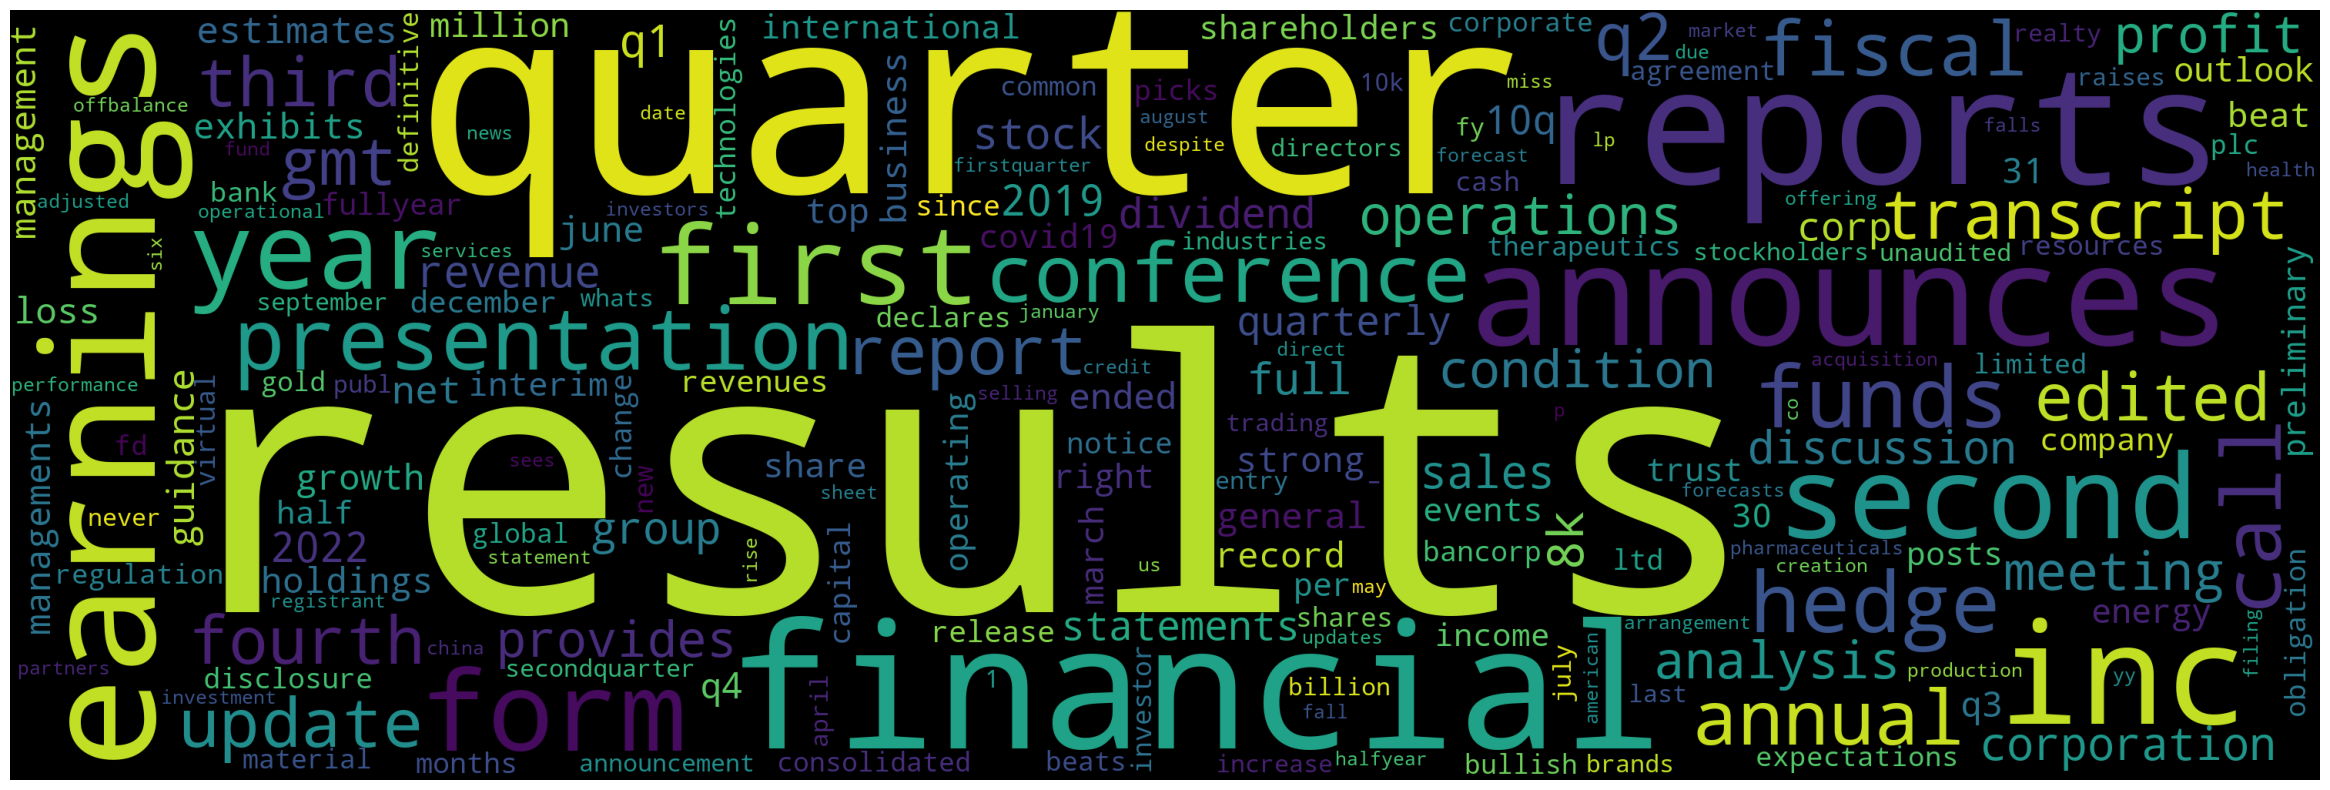

In [148]:
plt.figure(figsize=(30, 10))
plt.imshow(wc)
plt.axis("off")

# LA CATEGORIA 2 = finantial_result_quarter

# CATEGORIA 1 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

In [192]:
word1 = predictions_all.filter(predictions_all.prediction == 1)

In [193]:
word1_title_split = word1.select("title_splitted")

In [194]:
word1_title_split_rdd = word1_title_split.rdd.map(lambda x: " ".join(x[0]))
word1_title_split_rdd.take(3)

['looking into the truth about modern workplace environments',
 "medicinal cannabis substitute can treat parkinson's disease",
 '2020 trends to watch in us beverage']

In [195]:
word1_title_cleaned =word1_title_split_rdd.map(clean_text)
word1_title_cleaned.take(5)

['looking into the truth about modern workplace environments',
 'medicinal cannabis substitute can treat parkinsons disease',
 'trends to watch in us beverage',
 'my experience of surviving cancer twice',
 'alcoholfree craft beer from partake looks to fill whitespace of us market']

In [196]:
all_words1 = word1_title_cleaned.flatMap(lambda line: line.split())
all_words1.take(15)

['looking',
 'into',
 'the',
 'truth',
 'about',
 'modern',
 'workplace',
 'environments',
 'medicinal',
 'cannabis',
 'substitute',
 'can',
 'treat',
 'parkinsons',
 'disease']

In [197]:
all_words1_count = all_words1.map(lambda word: (word,1))
all_words1_count.take(3)

[('looking', 1), ('into', 1), ('the', 1)]

In [198]:
all_words.count()

225488

In [199]:
all_words1_rbk = all_words1_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words1_rbk.take(10)

[('0', 8),
 ('000', 11),
 ('000009', 1),
 ('00078', 1),
 ('001', 2),
 ('001438', 1),
 ('00178', 1),
 ('002', 2),
 ('0026', 2),
 ('003', 2)]

In [200]:
all_words1_rbk.persist()

PythonRDD[353] at RDD at PythonRDD.scala:53

In [201]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [203]:
stopwords = stopwords.words('english')

In [204]:
all_words1_rbk = all_words1_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words1_rbk.take(5)

[('0', 8), ('000', 11), ('000009', 1), ('00078', 1), ('001', 2)]

In [205]:
all_words1_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(26893, 'covid19'),
 (13031, 'market'),
 (9145, 'new'),
 (9144, 'global'),
 (5854, '–'),
 (5799, 'industry'),
 (5138, 'vaccine'),
 (5104, 'health'),
 (4600, 'report'),
 (4269, 'growth'),
 (3925, 'analysis'),
 (3871, 'impact'),
 (3788, 'digital'),
 (3674, 'researchandmarketscom'),
 (3472, 'data'),
 (3348, 'announces'),
 (3341, 'study'),
 (3139, 'us'),
 (3108, 'business'),
 (2983, 'covid')]

In [206]:
word_dict1 = {tupla[0]:float(tupla[1]) for tupla in all_words1_rbk.collect()}

In [208]:
wc1 = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict1)

(-0.5, 2999.5, 999.5, -0.5)

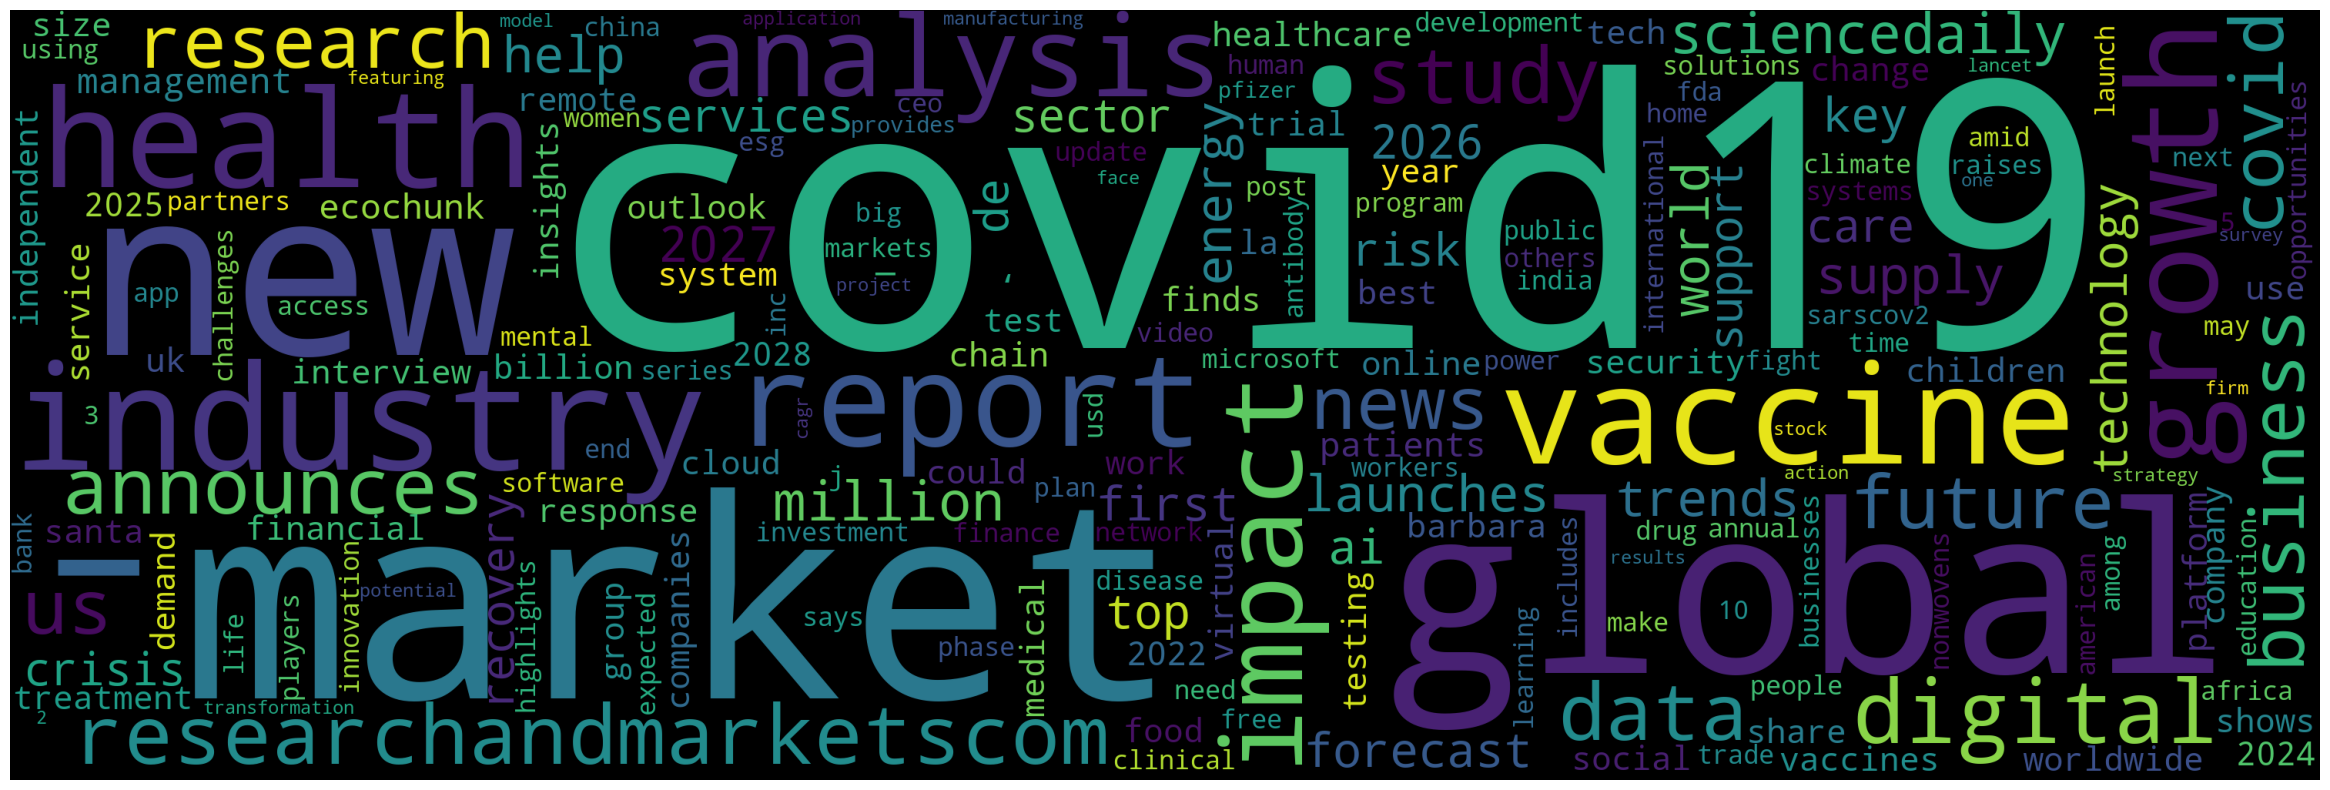

In [209]:
plt.figure(figsize=(30, 10))
plt.imshow(wc1)
plt.axis("off")

# LA CATEGORIA 1 = market_analysis 

# CATEGORIA 0 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

In [210]:
word0 = predictions_all.filter(predictions_all.prediction == 0)

In [211]:
word0_title_split = word0.select("title_splitted")

In [212]:
word0_title_split_rdd = word0_title_split.rdd.map(lambda x: " ".join(x[0]))
word0_title_split_rdd.take(3)

['japan raid, turkey arrests in widening ghosn probe',
 "pope's bodyguards criticised over slapping incident",
 'lebanon denies president welcomed fugitive ghosn']

In [213]:
word0_title_cleaned =word0_title_split_rdd.map(clean_text)
word0_title_cleaned.take(3)

['japan raid turkey arrests in widening ghosn probe',
 'popes bodyguards criticised over slapping incident',
 'lebanon denies president welcomed fugitive ghosn']

In [214]:
all_words0 = word0_title_cleaned.flatMap(lambda line: line.split())
all_words0.take(5)

['japan', 'raid', 'turkey', 'arrests', 'in']

In [215]:
all_words0_count = all_words0.map(lambda word: (word,1))
all_words0_count.take(3)

[('japan', 1), ('raid', 1), ('turkey', 1)]

In [216]:
all_words0.count()

3387169

In [217]:
all_words0_rbk = all_words0_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words0_rbk.take(10)

[('0', 37),
 ('00', 9),
 ('000', 7),
 ('001', 1),
 ('001c', 1),
 ('003', 1),
 ('007', 4),
 ('007s', 1),
 ('00’', 1),
 ('01', 30)]

In [218]:
all_words0_rbk.persist()

PythonRDD[374] at RDD at PythonRDD.scala:53

In [219]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [221]:
stopwords = stopwords.words('english')

AttributeError: 'list' object has no attribute 'words'

In [222]:
all_words0_rbk = all_words0_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words0_rbk.take(5)

[('0', 37), ('00', 9), ('000', 7), ('001', 1), ('001c', 1)]

In [223]:
all_words0_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(27523, 'covid19'),
 (24846, 'us'),
 (17153, 'new'),
 (16815, 'says'),
 (15893, 'covid'),
 (10331, 'stocks'),
 (10160, '‘'),
 (9807, 'vaccine'),
 (9500, 'cases'),
 (9436, 'stock'),
 (8600, 'trump'),
 (8256, 'uk'),
 (7918, 'china'),
 (7750, 'virus'),
 (7629, 'could'),
 (7353, 'amid'),
 (7146, 'oil'),
 (6148, 'may'),
 (5880, 'market'),
 (5819, '—')]

In [224]:
word_dict0 = {tupla[0]:float(tupla[1]) for tupla in all_words0_rbk.collect()}

In [225]:
wc0 = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict0)

(-0.5, 2999.5, 999.5, -0.5)

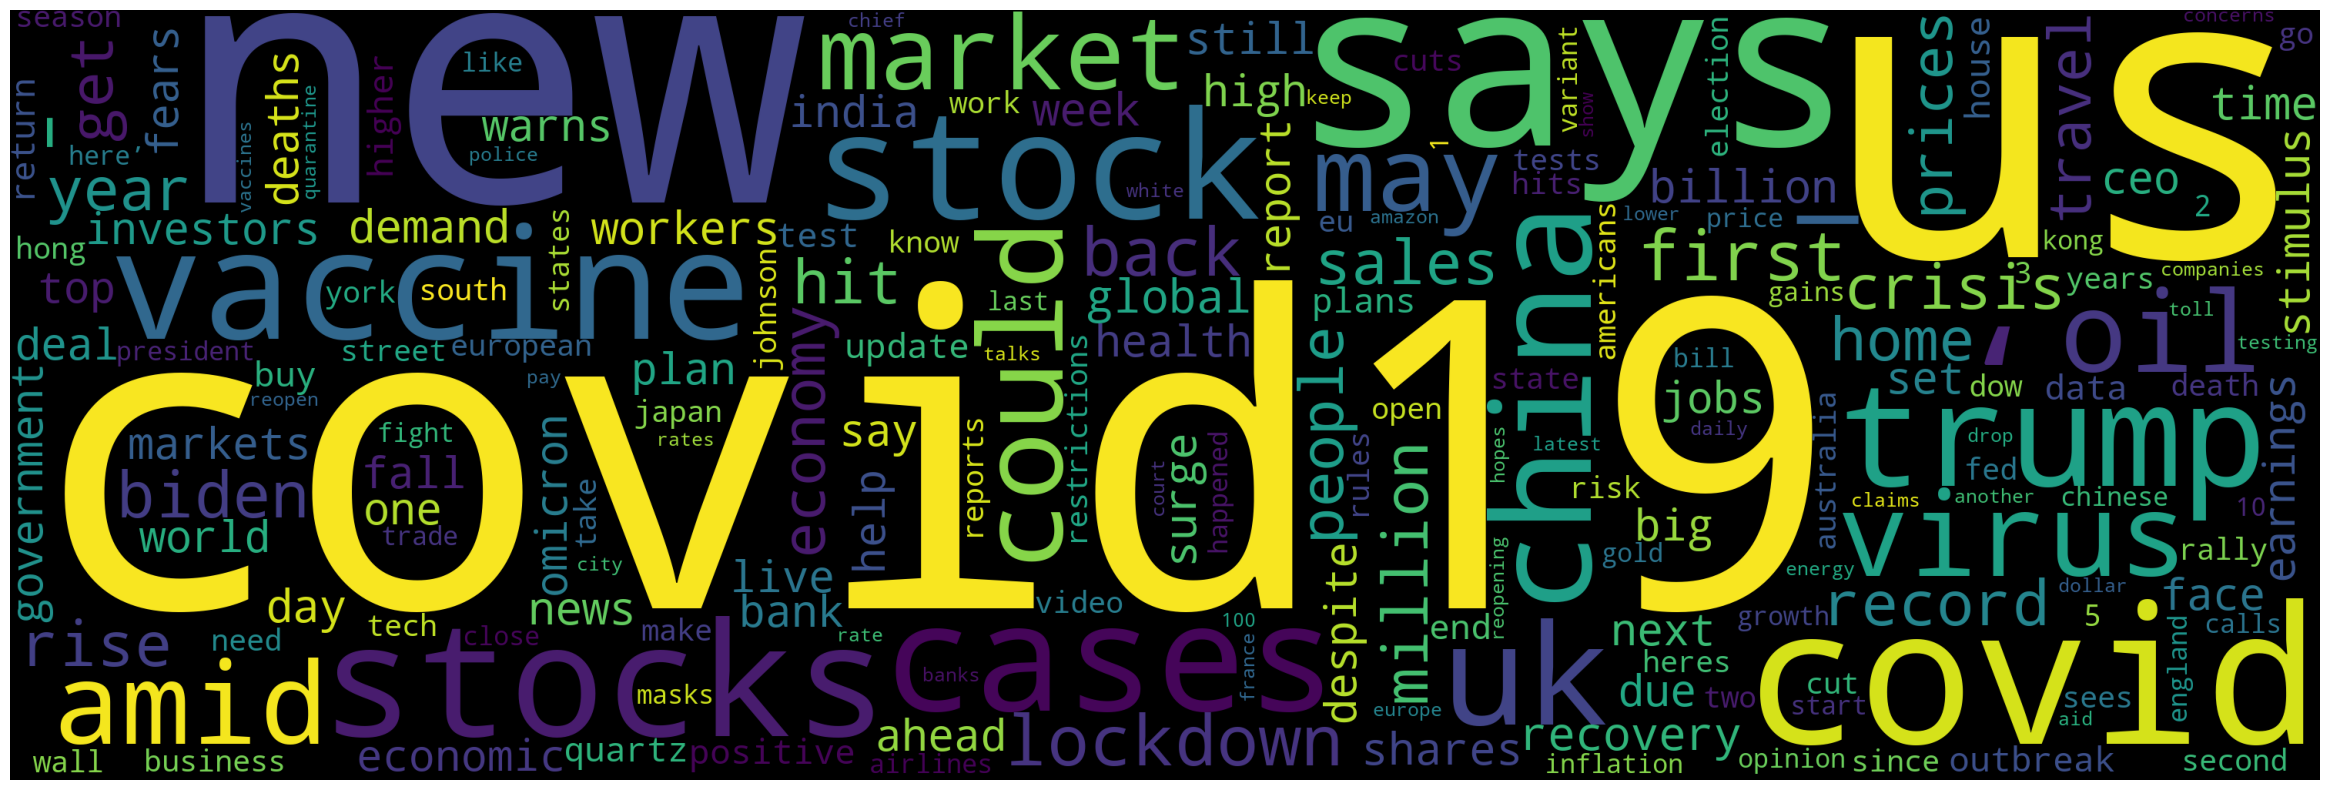

In [226]:
plt.figure(figsize=(30, 10))
plt.imshow(wc0)
plt.axis("off")

# LA CATEGORIA 1 = political_analysis 